In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#to create Basis \Phi
from sparse_recovery.compressed_sensing import create_Fourier_basis, create_normal_basis, create_orthonormal_basis

#to create signal b = \Phi\a
from sparse_recovery.compressed_sensing import create_signal

#to generate measures X
from sparse_recovery.compressed_sensing import get_measures

#to calculate coherence
from sparse_recovery.compressed_sensing import calculate_coherence

#to create noise
from sparse_recovery.compressed_sensing import create_noise_from_scratch, create_noise_from_mean_norm_signal

#to solve with l1 norm
from sparse_recovery.compressed_sensing import solve_compressed_sensing_l1

In [80]:
from sparse_recovery.plotters.utils import get_twin_axis, get_training_phases, FIGSIZE, LINEWIDTH, FIGSIZE_SMALL, FIGSIZE_LARGE, FIGSIZE_MEDIUM, FONTSIZE, LABEL_FONTSIZE, TICK_LABEL_FONTSIZE, MARKERSIZE
from sparse_recovery.plotters.img_show import custom_imshow

from matplotlib.lines import Line2D
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [90]:
# Example usage
n = 100  # Dimension of Phi
seed = None
# Generate Phi
#Phi = create_Fourier_basis(n) # Fourier basis
#Phi = create_orthonormal_basis(n, scaler=None, seed=seed) # Q of QR decomposition
#Phi = create_normal_basis(n, scaler=None, seed=seed, normalized=False) # Random Normal
Phi = np.eye(n)

N_max = n# int(0.9 * n)
all_N = list(range(1, N_max, 1)) # Number of measurements, N < n
all_tau = np.linspace(0, 1, 1*10+1)  # Range of tau values to test
all_tau = np.linspace(0, 1, 2*10+1) # Range of tau values to test

coherences = [ [] for _ in range(len(all_N)) ]
for i, N in tqdm(enumerate(all_N), total=len(all_N)) :
    for j, tau in enumerate(all_tau):
        coherence_value = 0
        n_trials = 10
        for k in range(n_trials):
            M, X = get_measures(N, Phi, tau=tau, variance=1/N, seed=None)
            #N_1 = int(tau*N)
            #M = M[:max(N_1, 1), :]
            #M = M[min(N_1, N-1):, :]
            coherence_value += calculate_coherence(M.T, Phi)
        coherences[i].append(coherence_value / n_trials)


100%|███████████████████████████████████████████| 99/99 [00:30<00:00,  3.27it/s]


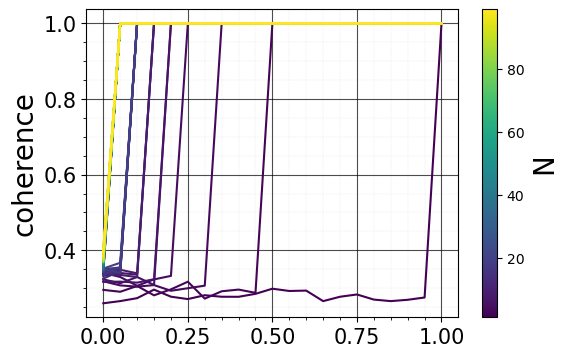

In [91]:
rows, cols = 1, 1
figsize=FIGSIZE
figsize=(cols*figsize[0], rows*figsize[1])
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(rows, cols, 1)
_, ax, _ = get_twin_axis(ax=ax, no_twin=True)
color_indices = np.linspace(0, 1, len(all_N))
colors = plt.cm.viridis(color_indices)
for i, N in enumerate(all_N):
    ax.plot(all_tau, coherences[i], label=f'N={N}', color=colors[i])
ax.set_xlabel('', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('coherence', fontsize=LABEL_FONTSIZE)
ax.tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.grid()
#ax.legend()
# Create a color bar for the sparsity levels `s`
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(all_N), vmax=max(all_N)))
sm.set_array([])  # We only need the colormap here, no actual data
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('N', fontsize=LABEL_FONTSIZE)

#plt.savefig(f"{LOG_DIR}/coherence_tau"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()

In [92]:
n = 100 # Dimension of the signal
seed = None
signal_distribution="normal"
#Phi = create_Fourier_basis(n) # Fourier basis
Phi = create_orthonormal_basis(n, scaler=None, seed=seed)
#Phi = np.random.randn(n, n) * (1/np.sqrt(n))
Phi = np.eye(n)

#SNR=10**8  # signal to noise ratio (np.inf for no noise)
SNR=np.inf

#all_s =  [1, 2]
all_s = [s for s in list(range(1, n+10, 10)) if s <= n] # Sparsity level <= n
#all_s = [s for s in list(range(1, n+10, 5)) if s <= n] # Sparsity level <= n

#all_N =  [15]
all_N = list(range(1, n+11, 10)) # Number of measurements N
#all_N = list(range(1, n+11, 1))

all_tau = np.arange(10+1)/10  # Range of tau values to test
all_tau = [0.0, 0.5, 1.0]
#all_tau = [0.0]

errors = {}
min_N_for_s = {}

for iii, tau in enumerate(all_tau):
    print(f"tau = {tau}, {iii+1}/{len(all_tau)}")
    errors[tau] = [ [] for _ in range(len(all_s)) ]
    min_N_for_s[tau] = [None for _ in range(len(all_s))]
    for i, s in tqdm(enumerate(all_s), total=len(all_s)):
        a_star, b_star = create_signal(n, s, signal_distribution, Phi, scaler=None, seed=None)
        for j, N in enumerate(all_N) :
            error_mean = 0
            n_trials = 4 # 10
            for k in range(n_trials):
                # Construct a random Gaussian measurement matrix X
                M, X = get_measures(N, Phi, tau=tau, variance=1/N, seed=None)
                xi = create_noise_from_scratch(N, SNR, n, s, signal_distribution, Phi, scaler=None, seed=None)
                # Generate measurements y
                y_star = X @ a_star + xi # M @ b_star + xi
                # Solve the l1-minimization problem (P1) to recover a
                a = solve_compressed_sensing_l1(X, y_star, EPSILON=1e-8)
                # Evaluate the recovery
                recovery_error = np.linalg.norm(a - a_star, 2) / np.linalg.norm(a_star, 2)
                error_mean += recovery_error

            error_mean /= n_trials
            errors[tau][i].append(error_mean)
            if error_mean < 1e-6 and min_N_for_s[tau][i] is None:
                min_N_for_s[tau][i] = N
     

tau = 0.0, 1/3


100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


tau = 0.5, 2/3


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


tau = 1.0, 3/3


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]


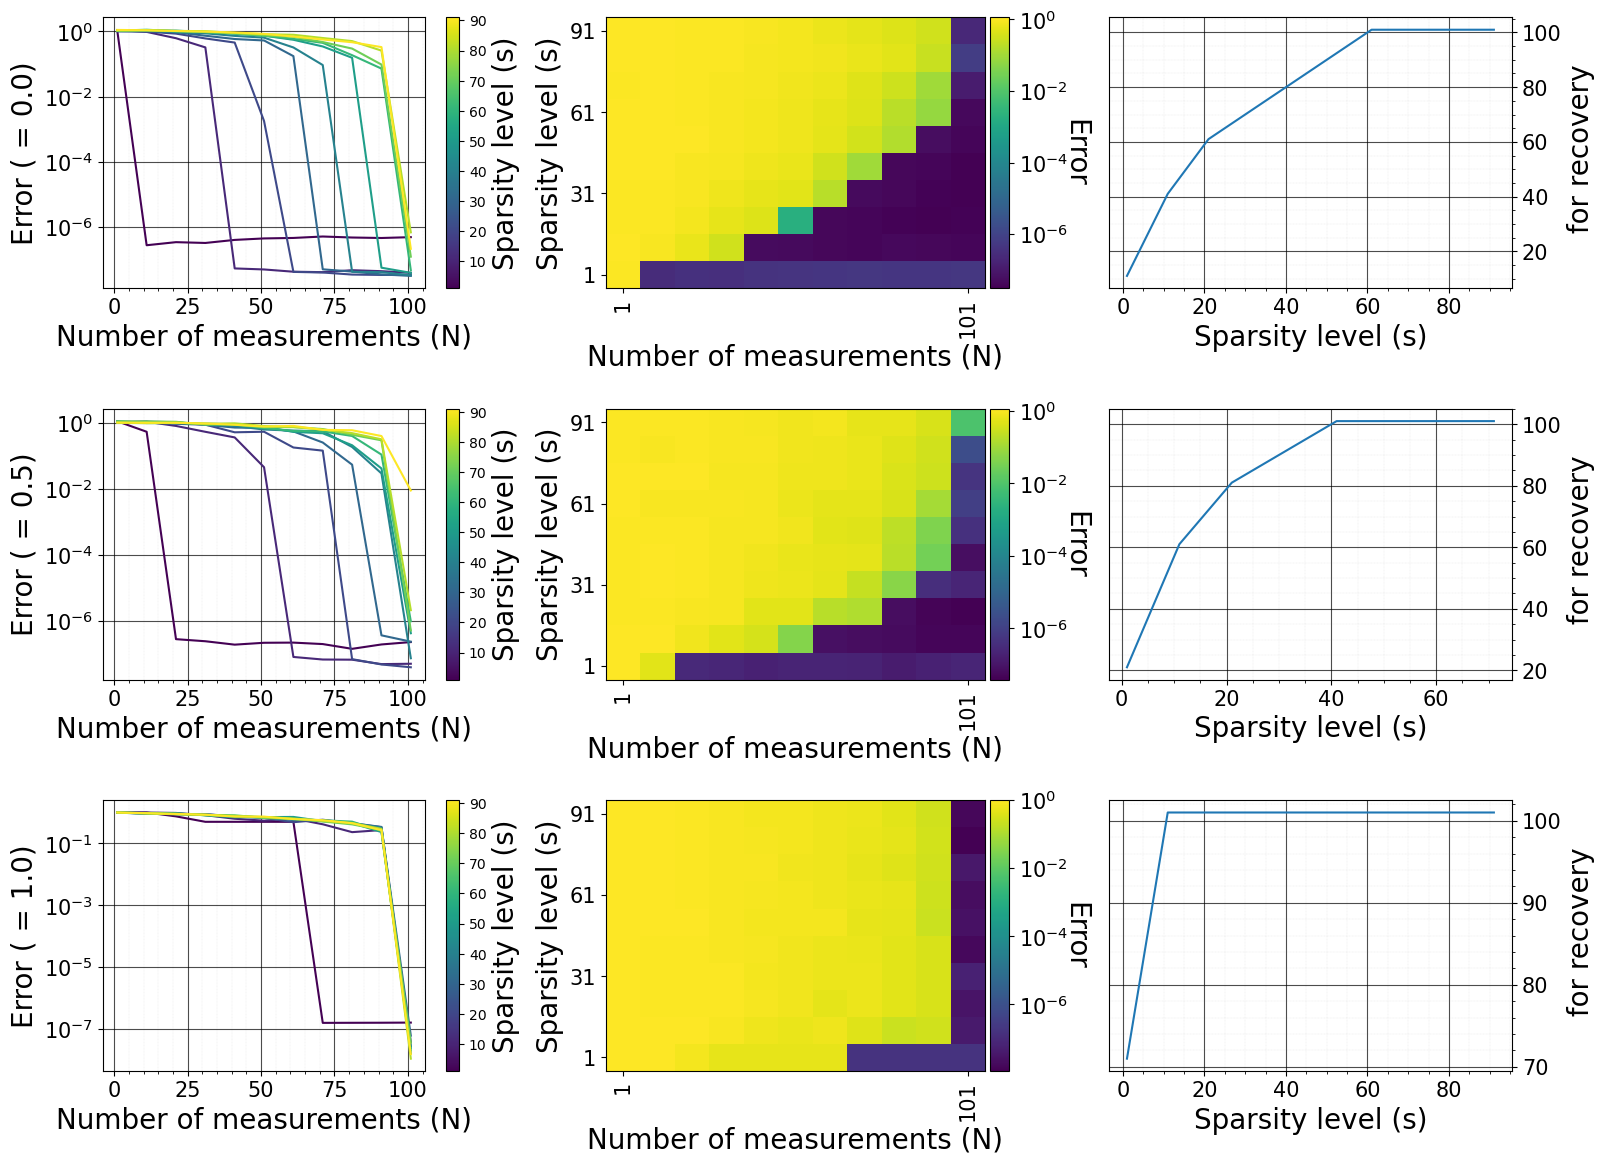

In [93]:
from matplotlib.colors import LogNorm

rows, cols = len(all_tau), 3
figsize=FIGSIZE
figsize=(cols*figsize[0], rows*figsize[1])
fig = plt.figure(figsize=figsize)

for iii, tau in enumerate(all_tau):
    ax = fig.add_subplot(rows, cols, 1+3*iii)
    _, ax, _ = get_twin_axis(ax=ax, no_twin=True)
    color_indices = np.linspace(0, 1, len(all_s))
    colors = plt.cm.viridis(color_indices)
    for i, s in enumerate(all_s):
        ax.plot(all_N, errors[tau][i], label=f's={s}', color=colors[i])
    ax.set_xlabel('Number of measurements (N)', fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(f'Error ( = {round(tau, 3)})', fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
    ax.set_yscale('log')
    #ax.grid()
    #ax.legend()
    # Create a color bar for the sparsity levels `s`
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(all_s), vmax=max(all_s)))
    sm.set_array([])  # We only need the colormap here, no actual data
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Sparsity level (s)', fontsize=LABEL_FONTSIZE)

    ax = fig.add_subplot(rows, cols, 2+3*iii)
    img_data = np.array(errors[tau]) # (M, N) = (len(all_s), len(all_N))
    img = custom_imshow(
        img_data, ax=ax, fig=fig, add_text=False,
        hide_ticks_and_labels=False, xticklabels=all_N, yticklabels=all_s,
        filter_step_xticks=10, filter_step_yticks=3, log_x=False, log_y=False, base=10,
        rotation_x=90, rotation_y=0,
        x_label="Number of measurements (N)",  y_label="Sparsity level (s)",
        # Use LogNorm to apply a logarithmic scale
        colormesh_kwarg={"shading":'auto', "cmap":'viridis', 'norm':LogNorm(vmin=img_data.min(), vmax=img_data.max())},
        imshow_kwarg={},
        colorbar=True, colorbar_label='Error',
        label_fontsize=LABEL_FONTSIZE,
        ticklabel_fontsize=TICK_LABEL_FONTSIZE,
        show=False, fileName=None, dpf=None
    )

    ax = fig.add_subplot(rows, cols, 3+3*iii)
    _, ax, _ = get_twin_axis(ax=ax, no_twin=True)
    ax.plot(all_s, min_N_for_s[tau], label="true")
    #ax.plot(all_s, [s * np.log(n) for s in all_s], label="predict")
    ax.set_xlabel('Sparsity level (s)', fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(' for recovery', fontsize=LABEL_FONTSIZE)
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.yaxis.set_label_position("right")  # Move y-axis label to the right
    ax.tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
    #ax.legend()
    #ax.grid()

# Adjust layout and add padding
fig.tight_layout(pad=2)  # Adjust padding between plots
plt.subplots_adjust(right=0.85)  # Adjust right boundary of the plot to fit color bar

# #plt.savefig(f"{LOG_DIR}/compressed_sensing_convex_programming_all"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')
# plt.savefig(f"{LOG_DIR}/compressed_sensing_convex_programming"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()

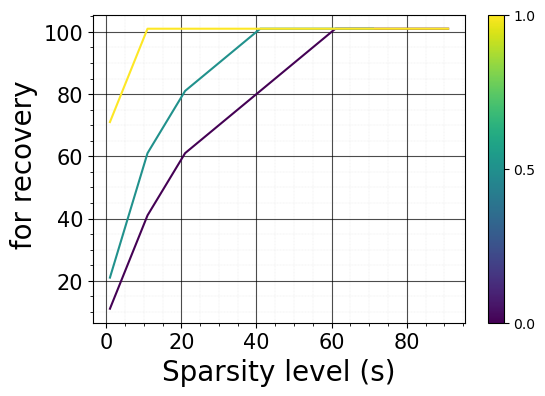

In [94]:

rows, cols = 1, 1
figsize=FIGSIZE
figsize=(cols*figsize[0], rows*figsize[1])
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(rows, cols, 1)
_, ax, _ = get_twin_axis(ax=ax, no_twin=True)
color_indices = np.linspace(0, 1, len(all_tau))
colors = plt.cm.viridis(color_indices)
for i, tau in enumerate(all_tau):
    ax.plot(all_s, min_N_for_s[tau], label=f'={round(tau, 3)}', color=colors[i])

ax.set_xlabel('Sparsity level (s)', fontsize=LABEL_FONTSIZE)
ax.set_ylabel(' for recovery', fontsize=LABEL_FONTSIZE)
ax.tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
# Create a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(all_tau), vmax=max(all_tau)))
sm.set_array([])  # We only need the colormap here, no actual data
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('', fontsize=LABEL_FONTSIZE)
# Set the ticks to correspond to the values in `all_tau`
cbar.set_ticks(all_tau)  # Sets tick positions based on `all_tau`
cbar.set_ticklabels([str(tau) for tau in all_tau])  # Sets tick labels to match `all_tau`

#plt.savefig(f"{LOG_DIR}/compressed_sensing_convex_programming_N_min"  + '.pdf', dpi=300, bbox_inches='tight', format='pdf')

plt.show()